# Data Analysis 1: transforming data and basic stats
[Check here](#Here)

# Necessary imports

In [3]:
# basic python
import os
import warnings
from collections import namedtuple

# data analysis
import numpy as np
import pandas as pd
from scipy.stats import gmean

import skbio.stats.composition as coda

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [4]:
warnings.filterwarnings('ignore')

---

# Constants

In [7]:
rareEarthsYttr = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Y', 'Er', 'Tm', 'Yb', 'Lu']

# Functions

In [9]:
loadcsv = lambda x: pd.read_csv(x, sep=';', index_col=[0, 1, 2, 3])

# Reading and joining DataFrames

In [11]:
os.getcwd()

'E:\\LA-ICP-MS\\ICP data analysis\\Data analysis\\Repos\\Factors'

In [12]:
ppm = loadcsv('Data/ppm_sing_profiles_3mm.csv')
paas = loadcsv('Data/paas_sing_profiles_3mm.csv')
spots = loadcsv('Data/spots_sing_profiles_3mm.csv')

---

In [14]:
spots_with_cuts = spots.copy()

In [15]:
borders = zip(np.linspace(0, 3, 6)[:-1].round(1).astype(str), np.linspace(0, 3, 6)[1:].round(1).astype(str))
bone_cut_labels = ['-'.join(list(range)) + ' mm' for range in borders]

In [16]:
bone_cuts = pd.cut(spots_with_cuts['mmDist'], 5, labels=bone_cut_labels)

In [17]:
spots_with_cuts['distCat'] = bone_cuts

In [18]:
spots_with_cuts

Genus    Locality skeletPart tissueType  \
SampleID Line Spot SpotID                                                       
PR003    L2   2    PR-3_Ap21  Protoceratops  Bayan Dzak    humerus     Cortex   
              3    PR-3_Ap22  Protoceratops  Bayan Dzak    humerus     Cortex   
              5    PR-3_Ap24  Protoceratops  Bayan Dzak    humerus     Cortex   
              6    PR-3_Ap25  Protoceratops  Bayan Dzak    humerus     Cortex   
              7    PR-3_Ap26  Protoceratops  Bayan Dzak    humerus     Cortex   
...                                     ...         ...        ...        ...   
TS031    L1   2    T31_2        Tarbosaurus   Altan Uul      tibia     Cortex   
              3    T31_3        Tarbosaurus   Altan Uul      tibia     Cortex   
              4    T31_4        Tarbosaurus   Altan Uul      tibia     Cortex   
              5    T31_5        Tarbosaurus   Altan Uul      tibia     Cortex   
              6    T31_6        Tarbosaurus   Altan Uul      tibia     Cortex   

                              mmThickness thickClass    mmDist    maxDist  \
SampleID Line Spot SpotID                                                   
PR003    L2   2    PR-3_Ap21     2.951805      short  0.426141   2.611134   
              3    PR-3_Ap22     2.951805      short  0.656013   2.611134   
              5    PR-3_Ap24     2.951805      short  1.090388   2.611134   
              6    PR-3_Ap25     2.951805      short  1.362011   2.611134   
              7    PR-3_Ap26     2.951805      short  1.522478   2.611134   
...                                   ...        ...       ...        ...   
TS031    L1   2    T31_2        30.636990       long  0.847304  40.335101   
              3    T31_3        30.636990       long  1.347863  40.335101   
              4    T31_4        30.636990       long  1.848388  40.335101   
              5    T31_5        30.636990       long  2.315427  40.335101   
              6    T31_6        30.636990       long  2.864004  40.335101   

                              profilePerc     distCat  
SampleID Line Spot SpotID                              
PR003    L2   2    PR-3_Ap21    16.320144  0.0-0.6 mm  
              3    PR-3_Ap22    25.123673  0.6-1.2 mm  
              5    PR-3_Ap24    41.759177  0.6-1.2 mm  
              6    PR-3_Ap25    52.161679  1.2-1.8 mm  
              7    PR-3_Ap26    58.307151  1.2-1.8 mm  
...                                   ...         ...  
TS031    L1   2    T31_2         2.100661  0.6-1.2 mm  
              3    T31_3         3.341663  1.2-1.8 mm  
              4    T31_4         4.582579  1.8-2.4 mm  
              5    T31_5         5.740477  1.8-2.4 mm  
              6    T31_6         7.100526  2.4-3.0 mm  

[155 rows x 10 columns]

---

# Plots

In [21]:
sns.set_theme(style='ticks', palette='colorblind')

In [22]:
paas_reey = paas.loc[:, rareEarthsYttr]

In [23]:
paas_data = paas_reey.merge(spots_with_cuts, left_index=True, right_index=True)

In [24]:
paas_melt = paas_data.melt(id_vars=spots_with_cuts.columns, value_name="Sample/PAAS", var_name='Element', ignore_index=False).reset_index()

## PAAS

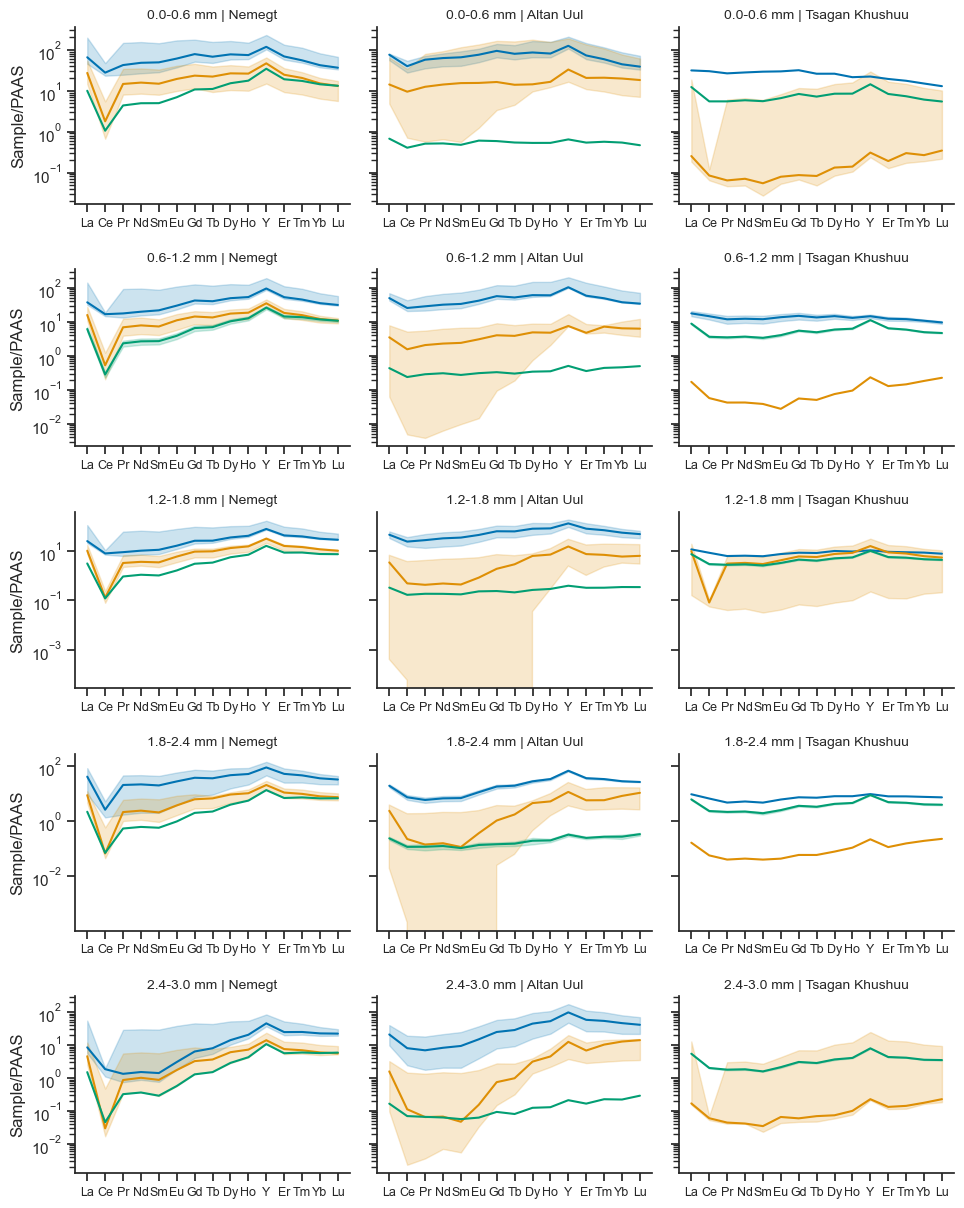

In [26]:
g = sns.relplot(data=paas_melt, 
            x='Element',
            y='Sample/PAAS',
            hue='thickClass',
            col='Locality',
            row='distCat',
            height=2.5,
            aspect=1.3,
            kind='line', 
            errorbar=('pi', 100), 
            estimator='median',
            facet_kws={'sharex' : False, 'sharey' : 'row'},
            col_order=['Nemegt', 'Altan Uul', 'Tsagan Khushuu'],
            legend=False
           ).set(yscale='log', xlabel='')

for ax in g.axes.flatten():
    title = ax.get_title()
    new_title = title.replace('distCat = ', '').replace('Locality = ', '')
    ax.set_title(new_title, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)

g

In [27]:
g.savefig('Plots and figures/Element plots/REY PAAS plots.jpg', dpi=300)

In [28]:
samples = paas_melt.SampleID.unique()

minspots = []
maxspots = []
maxspots_1_5 = []

for sample in samples:
    df = paas_melt[paas_melt.SampleID == sample]
    mindf = df[df.mmDist == df.mmDist.min()]
    maxdf_1_5 = df[(df.mmDist < 1.85) & (df.mmDist > 1.35)]
    maxdf_1_5 = maxdf_1_5[maxdf_1_5.mmDist == maxdf_1_5.mmDist.max()]
    maxdf_max = df[df.mmDist == df.mmDist.max()]

    minspots.append(mindf)
    maxspots_1_5.append(maxdf_1_5)
    maxspots.append(maxdf_max)

paas_melt_mins = pd.concat(minspots)
paas_melt_maxs = pd.concat(maxspots)
paas_melt_maxs_1_5 = pd.concat(maxspots_1_5)

In [29]:
ext_int = pd.DataFrame(
    data={
        'SampleID' : paas_melt_mins['SampleID'],
        'Line' : paas_melt_mins['Line'],
        'ext/int' : paas_melt_mins['Sample/PAAS'].to_numpy() / paas_melt_maxs['Sample/PAAS'].to_numpy(),
        'Element' : paas_melt_mins['Element'],
        'Locality' : paas_melt_mins['Locality'],
        'skeletPart' : paas_melt_mins['skeletPart'],
        'thickClass' : paas_melt_mins['thickClass'],
    }
)

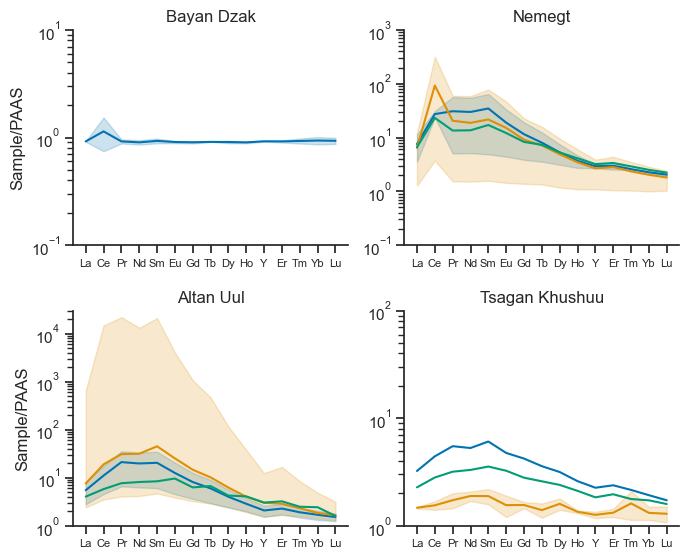

In [30]:
g2 = sns.relplot(
    data=ext_int, 
    x='Element',
    y='ext/int',
    hue='thickClass',
    col='Locality',
    col_wrap=2,
    height=3,
    aspect=1.2,
    kind='line', 
    errorbar=('pi', 100), 
    estimator='median',
    facet_kws={'sharex' : False, 'sharey' : False} #, 'sharey' : False}
    #col_order=['Nemegt', 'Altan Uul', 'Tsagan Khushuu']
).set(yscale='log') #, ylim=(0.1, 100000))

ylims = {'Bayan Dzak' : (0.1, 10), 'Nemegt' : (0.1, 1000), 'Altan Uul' : (1, 30_000), 'Tsagan Khushuu' : (1, 100)}

for loc, ax in g2.axes_dict.items():
    title = ax.get_title()
    new_title = title.replace('Locality = ', '')
    #new_title = title.replace('distCat = ', '').replace('Locality = ', '')
    ax.set_title(new_title, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylim(ylims[loc])
    ax.set_xlabel('')
    
g2.set_axis_labels(y_var='Sample/PAAS')
g2._legend.remove()
g2

In [31]:
g2.savefig('Plots and figures/Element plots/Enrichment ext-int.jpg', dpi=300)

## Ca fraction

In [33]:
ppm_frame_closed = pd.DataFrame(
    data=coda.closure(ppm.fillna(0.00001)),
    index=ppm.index,
    columns=ppm.columns
)

# ppm_frame_closed = pd.DataFrame(
#     data=coda.closure(ppm.fillna(0.00001)) * ppm3mm.sum(axis=1).median(),
#     index=ppm.index,
#     columns=ppm.columns
# )

In [34]:
ppm_closed_wide = ppm_frame_closed.merge(spots_with_cuts, left_index=True, right_index=True)

In [35]:
ppm_closed_wide.groupby(['skeletPart', 'SampleID']).agg({'Ca' : [gmean, 'median']})

Ca          
                        gmean    median
skeletPart SampleID                    
femur      TS021     0.931877  0.943689
           TS025     0.984453  0.985448
           TS030     0.975844  0.978650
humerus    PR003     0.937766  0.937435
metatarsal TF006     0.978855  0.979347
           TS022     0.985156  0.984268
radius     SF001     0.967000  0.970017
           SF002     0.961858  0.960206
rib        SF003     0.938411  0.937443
           TF029     0.982040  0.981936
           TS015     0.967161  0.974616
           TS024     0.984701  0.983998
           TS026     0.948339  0.951939
           TS027     0.967331  0.970035
tibia      PR006     0.949809  0.949409
           TS012     0.977603  0.980746
           TS013     0.982375  0.983588
           TS016     0.988782  0.989131
           TS020     0.985157  0.985501
           TS031     0.973000  0.974754

In [36]:
ppm_closed_wide.sort_values(['Locality', 'skeletPart', 'SampleID', 'Line', 'mmDist'], inplace=True)

Text(-0.001, 0.5, 'Ca [subcomposition fraction]')

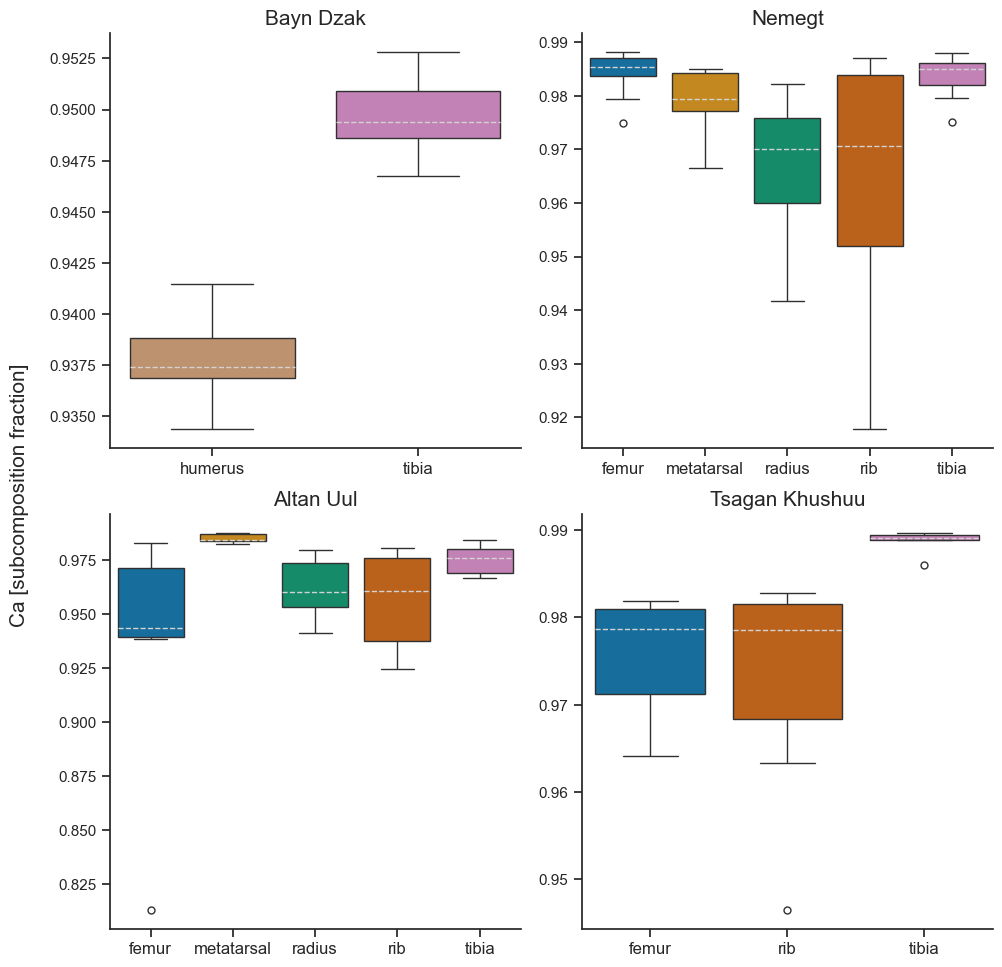

In [37]:
ca_plots = sns.catplot(
    data=ppm_closed_wide.reset_index(),
    x='skeletPart',
    y='Ca',
    hue='skeletPart',
    medianprops={'color' : 'lightgrey', 'linestyle' : '--', 'linewidth' : 1},
    kind='box',
    col='Locality',
    col_wrap=2,
    col_order=['Bayan Dzak', 'Nemegt', 'Altan Uul', 'Tsagan Khushuu'],
    #col='Locality',
    #row='Ratio',
    # kind='box',
    # height=5,
    # aspect=3,
    sharey=False,
    sharex=False,
    margin_titles=True
    #sharex=False,
    #col_order=['Nemegt', 'Altan Uul', 'Tsagan Khushuu']
) #.set(yscale='log').tight_layout()


for ax in ca_plots.axes.flatten():
    title = ax.get_title()
    new_title = title.replace('Locality = ', '').replace('Bayan Dzak', "Bayn Dzak")
    ax.set_title(new_title, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    
# ca_plots.legend(title='Skeletal part', ncols=2, loc='lower right')
# ca_plots.set_ylim(0.90, 1.0)
ca_plots.set(ylabel=None, xlabel=None) # ylabel='Ca [closed subcomposition fraction]',
ca_plots.figure.supylabel('Ca [subcomposition fraction]', fontsize=15, x=-0.001)

In [38]:
ca_plots.savefig('Plots and figures/Element plots/Ca contents - closed composition.jpg', dpi=300)

## U ratios

In [40]:
u_ratios = pd.concat([
    #rbsr.rename('Rb/Sr'), 
    (ppm.U / ppm.La).rename('U/La'),
    (ppm.U / ppm.Sm).rename('U/Sm'),
    (ppm.U / ppm.Yb).rename('U/Yb'),
    spots_with_cuts
], axis=1)

In [41]:
u_ratios_long = u_ratios.melt(ignore_index=False, var_name='Ratio', value_name='Val', id_vars=spots_with_cuts.columns).reset_index()

In [42]:
uratios_long_nem = u_ratios_long[u_ratios_long.Locality != 'Bayan Dzak']

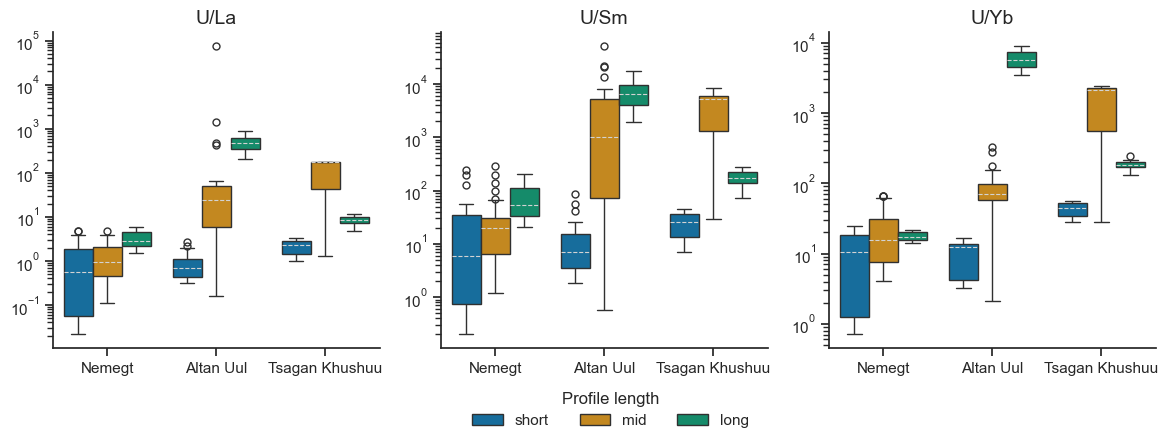

In [43]:
uree_catplots = sns.catplot(
    uratios_long_nem,
    x='Locality',
    y='Val',
    hue='thickClass',
    col='Ratio',
    #row='Ratio',
    kind='box',
    palette=sns.color_palette('colorblind'),
    medianprops={'color' : 'lightgrey', 'linestyle' : '--', 'linewidth' : 0.8},
    height=4,
    aspect=1,
    sharey=False,
    # col_order=['Nemegt', 'Altan Uul', 'Tsagan Khushuu']
).set(yscale='log', ylabel='', xlabel='').tight_layout()
sns.move_legend(uree_catplots, loc='lower center', title='Profile length', ncol=3, bbox_to_anchor=(0.48, -0.12))

for ax in uree_catplots.axes.flatten():
    title = ax.get_title()
    new_title = title.replace('Ratio = ', '')
    ax.set_title(new_title, fontsize=14)

uree_catplots

In [44]:
uree_catplots.savefig('Plots and figures/Element plots/U-REE ratios catplots.jpg', dpi=300)